#### This notebook analyses some zonal averages of the temperature response in the abrupt experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:44325 Dashboard: /proxy/43685/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,150429
1,output111,2096
2,output112,2096
3,output113,2096
4,output114,2096
5,output115,2096
6,output116,2096
7,output117,2096
8,output118,2096
9,output119,2096


In [7]:
yr_beg = '2400-01-16'

expt = '1deg_jra55_ryf_cont'
temp_cont = xr.concat([cc.querying.getvar(expt, 'temp', session, start_time = yr_beg, frequency = '1 monthly'),
                       cc.querying.getvar('output111', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output112', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output113', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output114', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output115', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output116', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output117', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output118', 'temp', session, frequency = '1 monthly'),
                       cc.querying.getvar('output119', 'temp', session, frequency = '1 monthly')], dim = 'time')

# I have to do this loop because the years 2455 onwards are stored as different experiments in this session, annoyingly... To be fixed. All it takes it reindexing the session.

In [6]:
# expt = '1deg_jra55_ryf_rcp45cool_spinup500'
# temp_cool = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 

In [7]:
# expt = '1deg_jra55_ryf_rcp45warm_spinup500'
# temp_warm = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')

In [8]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
temp_coolx1 = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
temp_warmx1 = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')

In [10]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
temp_coolx2 = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 

In [11]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
temp_warmx2 = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')

Load into memory to make the zonal average computations faster

In [12]:
# Yearly average and load into memory
temp_cont = temp_cont.groupby('time.year').mean(dim='time').load()
temp_coolx1 = temp_coolx1.groupby('time.year').mean(dim='time').load()
temp_warmx1 = temp_warmx1.groupby('time.year').mean(dim='time').load()
temp_coolx2 = temp_coolx2.groupby('time.year').mean(dim='time').load()
temp_warmx2 = temp_warmx2.groupby('time.year').mean(dim='time').load()

#### Zonally average

In [13]:
expt = '1deg_jra55_ryf_cont'
variable_to_average = temp_cont
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = xr.concat([cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg),
                 cc.querying.getvar('output111', 'dzt', session),
                 cc.querying.getvar('output112', 'dzt', session),
                 cc.querying.getvar('output113', 'dzt', session),
                 cc.querying.getvar('output114', 'dzt', session),
                 cc.querying.getvar('output115', 'dzt', session),
                 cc.querying.getvar('output116', 'dzt', session),
                 cc.querying.getvar('output117', 'dzt', session),
                 cc.querying.getvar('output118', 'dzt', session),
                 cc.querying.getvar('output119', 'dzt', session)], dim='time').groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_cont_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [45]:
# expt = '1deg_jra55_ryf_rcp45cool_spinup500'
# variable_to_average = temp_cool
# coord = 'geolat_t'
# variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
# yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
# bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
# dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
# area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
# dVol = (dzt * area_t).load() #Volume of cells

# histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
# histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
# temp_cool_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [49]:
# expt = '1deg_jra55_ryf_rcp45warm_spinup500'
# variable_to_average = temp_warm
# coord = 'geolat_t'
# variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
# yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
# bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
# dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
# area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
# dVol = (dzt * area_t).load() #Volume of cells

# histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
# histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
# temp_warm_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [19]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
variable_to_average = temp_coolx1
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_coolx1_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [20]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
variable_to_average = temp_warmx1
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_warmx1_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [21]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
variable_to_average = temp_coolx2
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_coolx2_zonal = (histTVolCoordDepth / histVolCoordDepth)

In [22]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
variable_to_average = temp_warmx2
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_warmx2_zonal = (histTVolCoordDepth / histVolCoordDepth)

#### Plot coolx1 vs coolx2

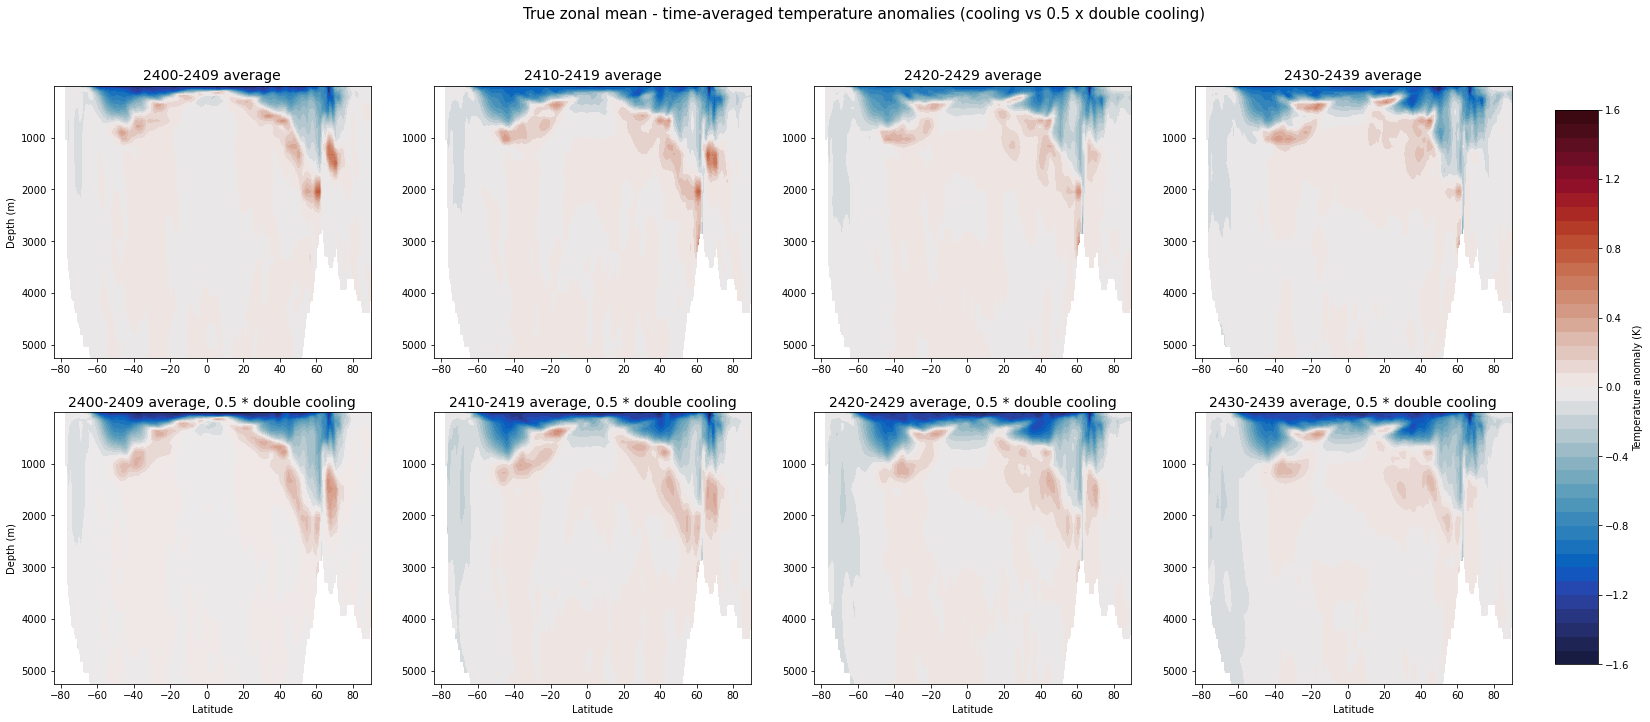

In [25]:
# Zonal average temperature anomaly time averages over different periods

fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (30, 11))
plt.suptitle('True zonal mean - time-averaged temperature anomalies (cooling vs 0.5 x double cooling)', fontsize=15)

coolx1_anom = temp_coolx1_zonal - temp_cont_zonal
coolx2_anom = 0.5*(temp_coolx2_zonal - temp_cont_zonal)
cmap = cm.cm.balance
levels = 45

beg = 2400
end = 2409
ncol = 0
coolx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('Depth (m)')
axs[0, ncol].set_xlabel('')
coolx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double cooling'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('Depth (m)')
axs[1, ncol].set_xlabel('Latitude')

beg = 2410
end = 2419
ncol = 1
coolx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
coolx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double cooling'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2420
end = 2429
ncol = 2
coolx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
coolx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double cooling'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2430
end = 2439
ncol = 3
coolx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
cbar_plot = coolx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double cooling'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(cbar_plot, cax = cbar_ax, label='Temperature anomaly (K)')

plt.savefig('cool_temperature_zonal_aves_2400-2440.jpg')

#### Plot warmx1 vs warmx2

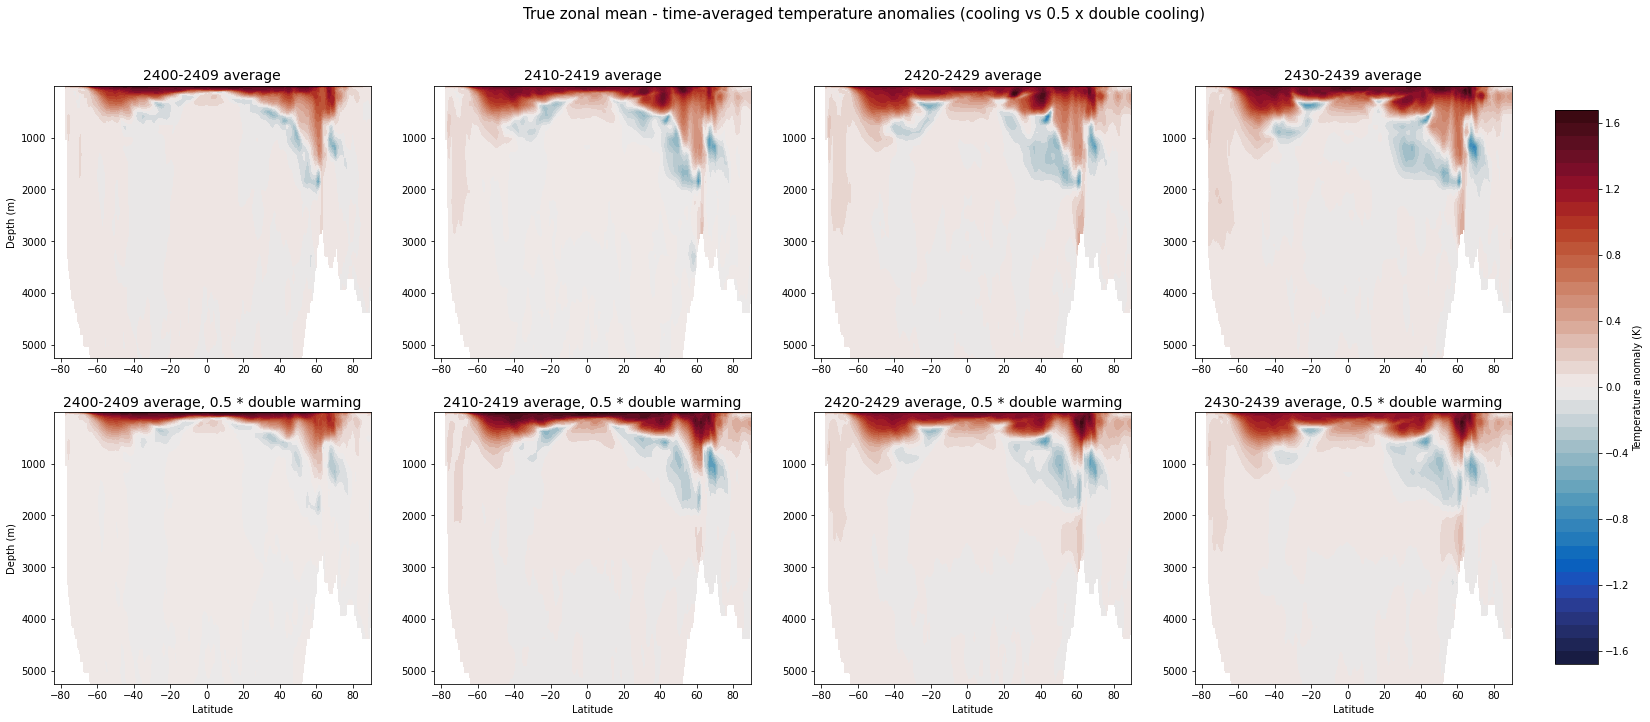

In [26]:
# Zonal average temperature anomaly time averages over different periods

fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (30, 11))
plt.suptitle('True zonal mean - time-averaged temperature anomalies (cooling vs 0.5 x double cooling)', fontsize=15)

warmx1_anom = temp_warmx1_zonal - temp_cont_zonal
warmx2_anom = 0.5*(temp_warmx2_zonal - temp_cont_zonal)
cmap = cm.cm.balance
levels = 45

beg = 2400
end = 2409
ncol = 0
warmx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('Depth (m)')
axs[0, ncol].set_xlabel('')
warmx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double warming'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('Depth (m)')
axs[1, ncol].set_xlabel('Latitude')

beg = 2410
end = 2419
ncol = 1
warmx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
warmx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double warming'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2420
end = 2429
ncol = 2
warmx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
warmx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double warming'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2430
end = 2439
ncol = 3
warmx1_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=14)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
cbar_plot = warmx2_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_title('{}-{} average, 0.5 * double warming'.format(beg, end), fontsize=14)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(cbar_plot, cax = cbar_ax, label='Temperature anomaly (K)')

plt.savefig('warm_temperature_zonal_aves_2400-2440.jpg')

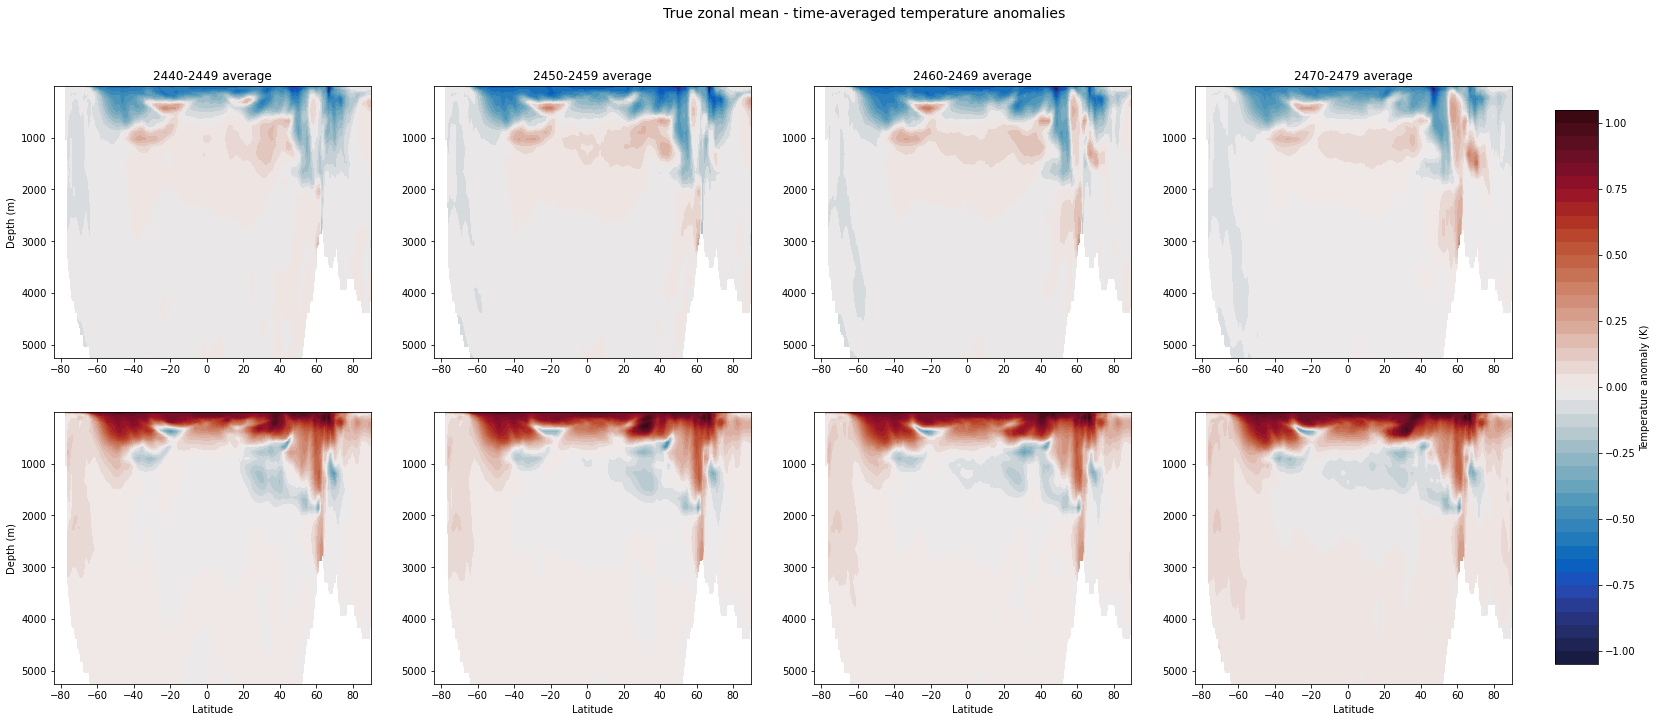

In [93]:
# Zonal average temperature anomaly time averages over different periods

fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (30, 11))
plt.suptitle('True zonal mean - time-averaged temperature anomalies', fontsize=14)

cool_anom = temp_cool_zonal - temp_cont_zonal
warm_anom = temp_warm_zonal - temp_cont_zonal
cmap = cm.cm.balance
levels = 45

beg = 2440
end = 2449
ncol = 0
cool_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, ncol].set_ylabel('Depth (m)')
axs[0, ncol].set_xlabel('')
warm_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_ylabel('Depth (m)')
axs[1, ncol].set_xlabel('Latitude')

beg = 2450
end = 2459
ncol = 1
cool_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
warm_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2460
end = 2469
ncol = 2
cool_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
warm_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

beg = 2470
end = 2479
ncol = 3
cool_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, ncol].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, ncol].set_ylabel('')
axs[0, ncol].set_xlabel('')
cbar_plot = warm_anom.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, ncol], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, ncol].set_ylabel('')
axs[1, ncol].set_xlabel('Latitude')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(cbar_plot, cax = cbar_ax, label='Temperature anomaly (K)')
 
#plt.savefig('temperature_zonal_aves_2440-2480.jpg')

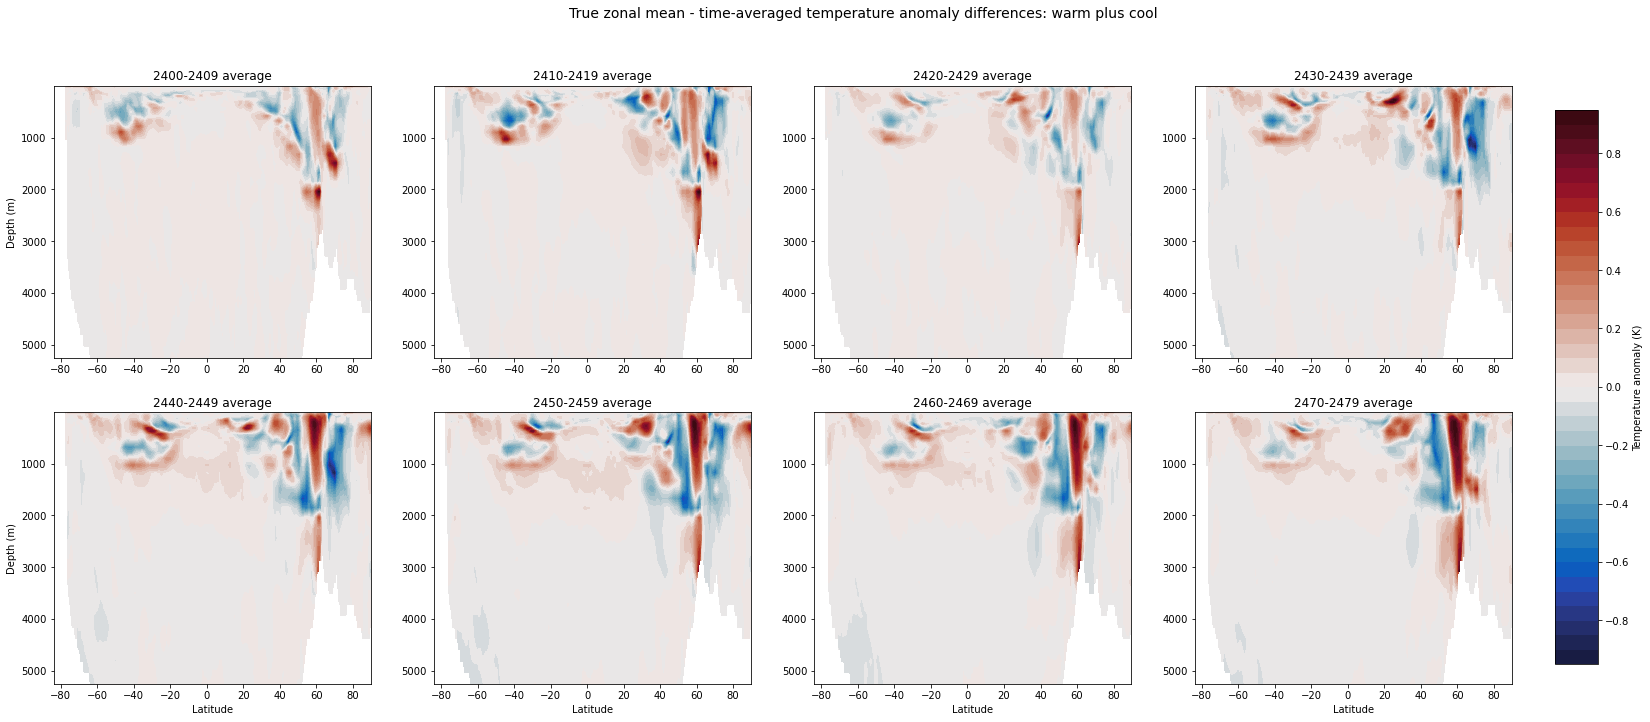

In [97]:
# Zonal average temperature anomaly time averages over different periods, differences

fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (30, 11))
plt.suptitle('True zonal mean - time-averaged temperature anomaly differences: warm plus cool', fontsize=14)

cool_anom = temp_cool_zonal - temp_cont_zonal
warm_anom = temp_warm_zonal - temp_cont_zonal
difference = warm_anom + cool_anom
cmap = cm.cm.balance
levels = 45

beg = 2400
end = 2409
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, 0], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, 0].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, 0].set_ylabel('Depth (m)')
axs[0, 0].set_xlabel('')

beg = 2410
end = 2419
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, 1], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, 1].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlabel('')

beg = 2420
end = 2429
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, 2], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, 2].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, 2].set_ylabel('')
axs[0, 2].set_xlabel('')

beg = 2430
end = 2439
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[0, 3], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[0, 3].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[0, 3].set_ylabel('')
axs[0, 3].set_xlabel('')


beg = 2440
end = 2449
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, 0], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, 0].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[1, 0].set_ylabel('Depth (m)')
axs[1, 0].set_xlabel('Latitude')

beg = 2450
end = 2459
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, 1], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, 1].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlabel('Latitude')

beg = 2460
end = 2469
difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, 2], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, 2].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[1, 2].set_ylabel('')
axs[1, 2].set_xlabel('Latitude')

beg = 2470
end = 2479
cbar_plot = difference.sel(year=slice(beg, end)).mean('year').plot.contourf(ax = axs[1, 3], cmap = cmap, levels=levels, yincrease=False, add_colorbar=False)
axs[1, 3].set_title('{}-{} average'.format(beg, end), fontsize=12)
axs[1, 3].set_ylabel('')
axs[1, 3].set_xlabel('Latitude')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(cbar_plot, cax = cbar_ax, label='Temperature anomaly (K)')
 
#plt.savefig('temperature_zonal_aves_differences.jpg')